# Проект на тему: анализ песен платформы Spotify с использованием алгоритмов машинного обучения

**Цель -** создать наилучшую модель для прогнозирования популярности песни на основе анализа определённых метрик

**Задачи**
* Спроектировать архитектуру базы данных для хранения информации о песнях
* Заполнить строки в БД предобработанными данными
* Провести разведочный анализ данных
* Построить простую модель
* Провести эксперименты с моделями машинного обучения и выбрать лучшую.

## Работа с базой данных

Создадим базу данных на основе MySQL

In [ ]:
%%sql
CREATE TABLE artists(
                        id INT PRIMARY KEY,
                        name_artist VARCHAR(100)
);

CREATE TABLE albums(
                       id INT PRIMARY KEY,
                       name_album VARCHAR(250)
);

CREATE TABLE genres(
                       id INT PRIMARY KEY,
                       name_genre VARCHAR(20)
);

CREATE TABLE songs(
                      id VARCHAR(22) PRIMARY KEY,
                      name_song VARCHAR(520),
                      id_artist1 INT,
                      id_artist2 INT,
                      id_artist3 INT,
                      id_artist4 INT,
                      id_artist5 INT,
                      id_artist6 INT,
                      id_artist7 INT,
                      album_id INT,
                      FOREIGN KEY (id_artist1) REFERENCES artists(id),
                      FOREIGN KEY (id_artist2) REFERENCES artists(id),
                      FOREIGN KEY (id_artist3) REFERENCES artists(id),
                      FOREIGN KEY (id_artist4) REFERENCES artists(id),
                      FOREIGN KEY (id_artist5) REFERENCES artists(id),
                      FOREIGN KEY (id_artist6) REFERENCES artists(id),
                      FOREIGN KEY (id_artist7) REFERENCES artists(id),
                      FOREIGN KEY (album_id) REFERENCES albums(id)
);

CREATE TABLE rating(
                       song_id VARCHAR(22) PRIMARY KEY,
                       FOREIGN KEY (song_id) REFERENCES songs(id),
                       popularity FLOAT,
                       genre_id INT,
                       FOREIGN KEY (genre_id) REFERENCES genres(id),
                       NSFL INT,
                       duration INT,
                       danceability FLOAT,
                       energy FLOAT,
                       tone INT,
                       loudness FLOAT,
                       mode INT,
                       speechiness FLOAT,
                       acousticness FLOAT,
                       instrumentalness FLOAT,
                       liveness FLOAT,
                       valence FLOAT,
                       tempo FLOAT,
                       time_signature INT
);

Импорт библиотек

In [40]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import precision_score, recall_score, d2_absolute_error_score, mean_squared_error, mean_absolute_error

import MySQLdb

Загрузим базу данных 'spotify1' и наполним её информацией.

In [41]:
connect = MySQLdb.connect('localhost', 'Nick', 'Othx_WtB517', 'spotify1')
cursor = connect.cursor()


#Заполнение простых таблиц - id и имя
def easy_update_database(request, data_set, leng_col):
    easy_set = [(i, data_set[i]) for i in range(leng_col)]
    cursor.executemany(request, easy_set)

#У одной композиции может быть множество авторов, в некоторых исключениях их число доходит до 30. Если авторов слишком много, то внесём информацию по первым 7 для снижения затраты ресурсов.
dataset = pd.read_csv("dataset.csv")
leng_column = len(dataset['track_id'])
unfiltred_artists = dataset['artists'].to_list()
artists = set()
song_artists = [['None'] * 7 for _ in range(leng_column)]
for i in range(leng_column):
    split_artist = str(unfiltred_artists[i]).split(';')
    for j in range(min(len(split_artist), 7)):
        if split_artist[j] != 'NaN':
            artists.add(split_artist[j])
        song_artists[i][j] = split_artist[j]

album_list = list(set(dataset['album_name'].to_list()))
genre_list = list(set(dataset['track_genre'].to_list()))
#Заполнение таблицу "артисты"
easy_update_database("INSERT INTO artists (id, name_artist) VALUES(%s, %s)", list(artists), len(artists))
print(cursor.rowcount, "was inserted.")
#Заполнение таблицу "альбомы"
easy_update_database("INSERT INTO albums (id, name_album) VALUES(%s, %s)", album_list, len(album_list))
print(cursor.rowcount, "was inserted.")
#Заполнение таблицу "жанры"
easy_update_database("INSERT INTO genres (id, name_genre) VALUES(%s, %s)", genre_list, len(genre_list))
print(cursor.rowcount, "was inserted.")

29562 was inserted.
46589 was inserted.
114 was inserted.


In [42]:
#Создаём словарь с ссылкой на таблицу artists
artist_id_map = {}
if artists:
    placeholders = ', '.join(['%s'] * len(artists))
    cursor.execute(
        f"SELECT id, name_artist FROM artists WHERE name_artist IN ({placeholders})",
        list(artists)
    )
    artist_id_map = {name: artist_id for artist_id, name in cursor.fetchall()}

#Создаём словарь с ссылкой на таблицу albums
unique_albums = set(dataset['album_name'][i] for i in range(leng_column))
album_id_map = {}
if unique_albums:
    placeholders = ', '.join(['%s'] * len(unique_albums))
    cursor.execute(
        f"SELECT id, name_album FROM albums WHERE name_album IN ({placeholders})",
        list(unique_albums)
    )
    album_id_map = {name: album_id for album_id, name in cursor.fetchall()}

#Заполнение таблицу songs - id, имя, авторы и альбом. Исключаем дубликаты через множество unique_songs
unique_songs = set()
song_list = []
for i in range(leng_column):
    song_entry = [dataset['track_id'][i], dataset['track_name'][i]]
    for j in range(7):
        artist_name = song_artists[i][j]
        if artist_name == 'None':
            song_entry.append(-1)
        else:
            song_entry.append(artist_id_map.get(artist_name, -1))
    album_name = dataset['album_name'][i]
    song_entry.append(album_id_map.get(album_name, -1))
    if(song_entry[0] not in unique_songs):
        unique_songs.add(song_entry[0])
        song_list.append(song_entry)
cursor.executemany(
    "INSERT INTO songs (id, name_song, id_artist1, id_artist2, id_artist3, id_artist4, id_artist5, id_artist6, id_artist7, album_id) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)", song_list
)
print(cursor.rowcount, "was inserted.")

89741 was inserted.


In [43]:
#Создаём словарь с ссылкой на таблицу genres
unique_genre = set(dataset['track_genre'][i] for i in range(leng_column))

genre_id_map = {}
if unique_genre:
    placeholders = ', '.join(['%s'] * len(unique_genre))
    cursor.execute(
        f"SELECT id, name_genre FROM genres WHERE name_genre IN ({placeholders})",
        list(unique_genre)
    )
    genre_id_map = {name: genre_id for genre_id, name in cursor.fetchall()}

#Заполнение таблицу rating - id песни, популярность(таргет), жанр, 18+, длительность, танцевальность, энергичность, тональность, модальность, текст, акустика, инструментал, живость, эмоциональность, темп, такт. Исключаем дубликаты через множество unique_songs
unique_rating = set()
ratings_list = []
for i in range(leng_column):
    genre_name = dataset['track_genre'][i]
    genre_id = genre_id_map.get(genre_name, -1)
    NSFL_bin = 0 if dataset['explicit'][i] == False else 1
    rating_entry = [dataset['track_id'][i], dataset['popularity'][i], genre_id, NSFL_bin, dataset['duration_ms'][i], dataset['danceability'][i], dataset['energy'][i], dataset['key'][i], dataset['loudness'][i], dataset['mode'][i], dataset['speechiness'][i], dataset['acousticness'][i], dataset['instrumentalness'][i], dataset['liveness'][i], dataset['valence'][i], dataset['tempo'][i], dataset['time_signature'][i]]
    if(rating_entry[0] not in unique_rating):
        unique_rating.add(rating_entry[0])
        ratings_list.append(rating_entry)
cursor.executemany(
    "INSERT INTO rating(song_id, popularity, genre_id, NSFL, duration, danceability, energy, tone, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)",
            ratings_list)
print(cursor.rowcount, "was inserted.")

89741 was inserted.


## 📊EDA - разведочный анализ данных
Таблица ***"rating"*** уже обработана для анализа с помощью библиотек pandas, matplotlib и seaborn. Загрузим данные из таблицы и посмотрим за первые записи.

In [60]:
cursor.execute("SELECT * FROM rating")
col = ['song_id', 'popularity', 'genre_id', 'NSFL', 'duration', 'danceability', 'energy', 'tone', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
ratingdf = pd.DataFrame(cursor.fetchall(), columns = col)

ratingdf.head(89741)

,song_id,popularity,genre_id,NSFL,duration,danceability,energy,tone,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0000vdREvCVMxbQTkS888c,44.0,52,1,160725,0.910,0.374,8,-9.844,0,0.1990,0.075700,0.003010,0.1540,0.432,104.042,4
1,000CC8EParg64OmTxVnZ0p,47.0,35,0,322933,0.269,0.516,0,-7.361,1,0.0366,0.406000,0.000000,0.1170,0.341,178.174,4
2,000Iz0K615UepwSJ5z2RE5,22.0,33,0,515360,0.686,0.560,5,-13.264,0,0.0462,0.001140,0.181000,0.1110,0.108,119.997,4
3,000qpdoc97IMTBvF8gwcpy,19.0,33,0,331240,0.519,0.431,6,-13.606,0,0.0291,0.000964,0.720000,0.0916,0.234,129.971,4
4,000RDCYioLteXcutOjeweY,62.0,58,0,190203,0.679,0.770,0,-3.537,1,0.1900,0.058300,0.000000,0.0825,0.839,161.721,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89736,7zz7iNGIWhmfFE7zlXkMma,22.0,87,0,144973,0.263,0.957,4,-6.887,1,0.0897,0.000023,0.006300,0.3780,0.204,172.932,4
89737,7zZa2WYKHrPJMzfhXgp4P2,5.0,22,0,245186,0.389,0.540,8,-5.879,0,0.0285,0.809000,0.000000,0.1320,0.463,159.877,3
89738,7zZl0xcrbYe7wFzhLTCn7E,42.0,13,0,219200,0.679,0.673,4,-7.504,0,0.0262,0.039200,0.000437,0.0690,0.854,113.970,4
89739,7zZON8d3Er93T7hDHrDao6,28.0,101,0,207866,0.751,0.839,2,-7.551,1,0.0490,0.523000,0.000000,0.2400,0.730,91.084,4


Посмотрим на точечные диаграммы этих переменных и удалим все выбросы

79208


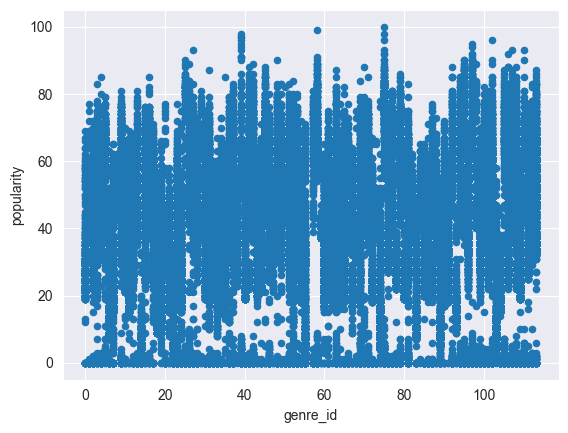

In [45]:
ratingdf.plot.scatter(x=2, y='popularity');
ratingdf = ratingdf[ratingdf[col[1]] > 1 & (ratingdf[col[1]] < 90)]
print(len(ratingdf))

77961


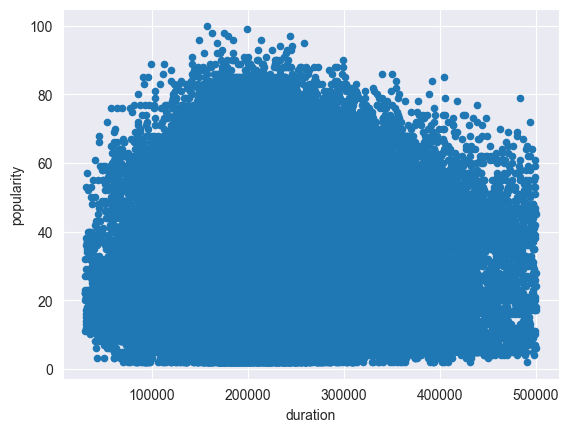

In [46]:
ratingdf = ratingdf[(ratingdf[col[4]] > 30000) & (ratingdf[col[4]] < 500000)]
print(len(ratingdf))
ratingdf.plot.scatter(x=col[4], y='popularity');

75968


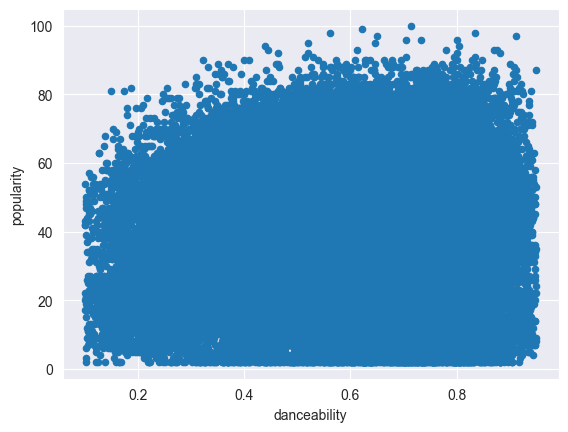

In [49]:
ratingdf = ratingdf[(ratingdf[col[5]] > 0.1) & (ratingdf[col[5]] < 0.95)]
ratingdf.plot.scatter(x=5, y='popularity');
print(len(ratingdf))

75968


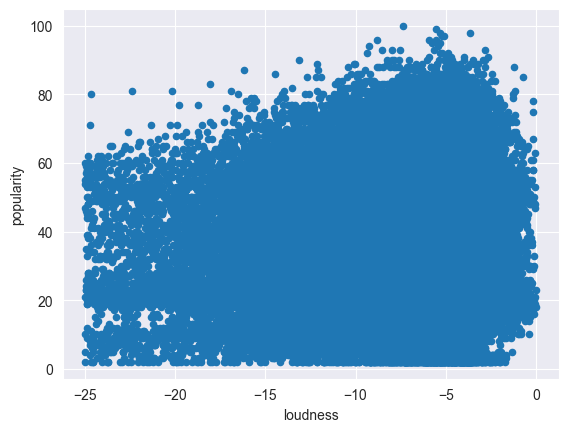

In [50]:
ratingdf = ratingdf[(ratingdf[col[8]] > -25) & (ratingdf[col[8]] < 0)]
print(len(ratingdf))
ratingdf.plot.scatter(x=col[8], y='popularity');

73481


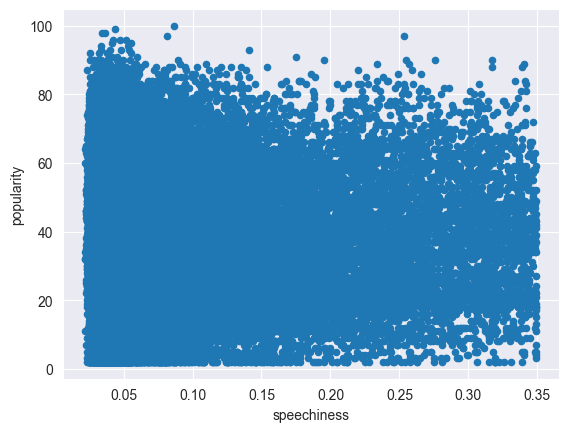

In [51]:
ratingdf = ratingdf[(ratingdf[col[10]] > 0.01) & (ratingdf[col[10]] < 0.35)]
print(len(ratingdf))
ratingdf.plot.scatter(x=col[10], y='popularity');

73481


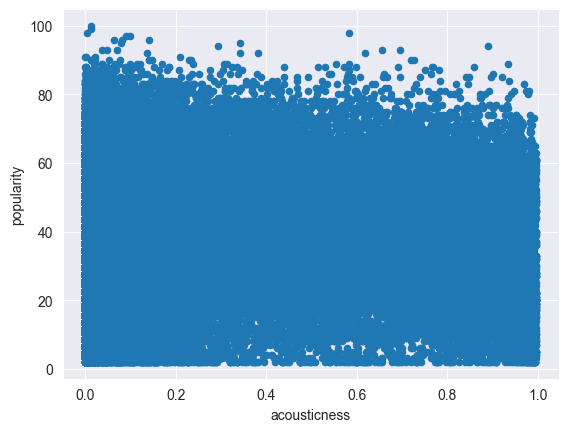

In [52]:
ratingdf.plot.scatter(x=11, y='popularity');
print(len(ratingdf))

73481


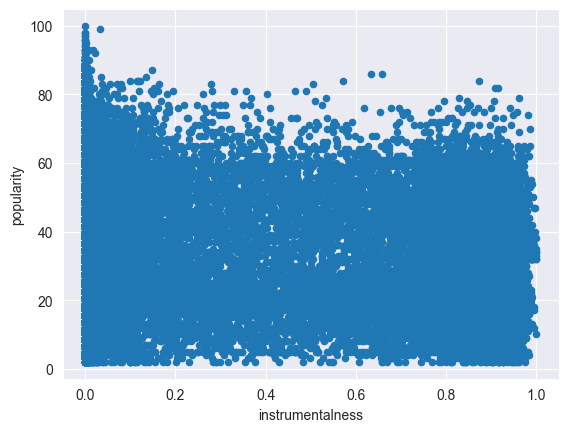

In [53]:
ratingdf = ratingdf[(ratingdf[col[5]] > 0.1) & (ratingdf[col[5]] < 0.95)]
ratingdf.plot.scatter(x=12, y='popularity');
print(len(ratingdf))

72144


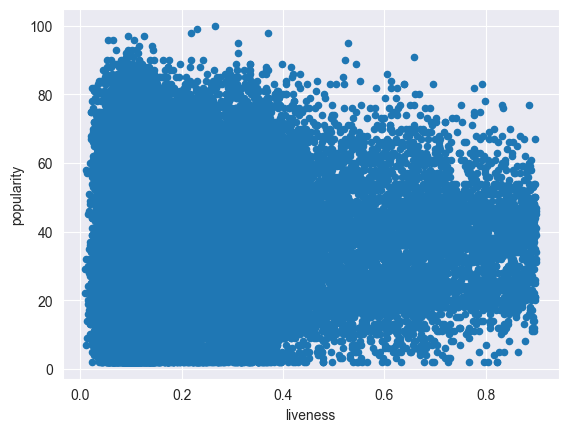

In [54]:
ratingdf = ratingdf[(ratingdf[col[13]] < 0.9)]
ratingdf.plot.scatter(x=13, y='popularity');
print(len(ratingdf))

72144


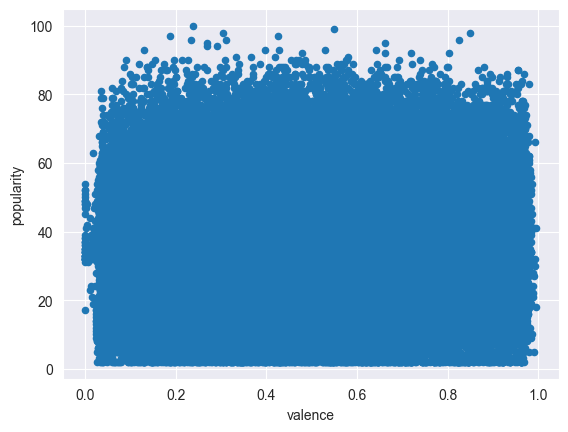

In [55]:
ratingdf.plot.scatter(x=14, y='popularity');
print(len(ratingdf))

71651


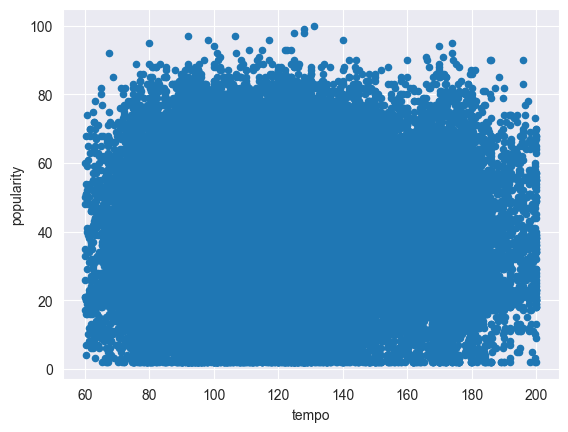

In [56]:
ratingdf = ratingdf[(ratingdf[col[15]] > 60) & (ratingdf[col[15]] < 200)]
print(len(ratingdf))
ratingdf.plot.scatter(x=col[15], y='popularity');

## Feature Engineering
Проведём моделирование и рассчитаем линейную регрессию с помощью библиотеки statsmodel API. Создадим простую модель линейной регрессии и изучим её вывод.

In [57]:
X = ratingdf[col[2:]]
Y = ratingdf[col[1]]
X = sm.add_constant(X, prepend=False)
model = OLS(Y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     510.2
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:34:48   Log-Likelihood:            -3.0453e+05
No. Observations:               71651   AIC:                         6.091e+05
Df Residuals:                   71635   BIC:                         6.092e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
genre_id             0.0174      0.002  

Исходя из результатов, мы можем видеть, что p-значение для такой переменной, как **тон**, больше порога статистической значимости. Следовательно, нулевая гипотеза для данной метрики может быть отклонена. Исключим её из набора.

In [58]:
x_column = ['genre_id', 'NSFL', 'duration', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
X = ratingdf[x_column]
Y = ratingdf[col[1]]

X = sm.add_constant(X, prepend=False)

model = OLS(Y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     546.5
Date:                Sat, 31 May 2025   Prob (F-statistic):               0.00
Time:                        13:40:18   Log-Likelihood:            -3.0453e+05
No. Observations:               71651   AIC:                         6.091e+05
Df Residuals:                   71636   BIC:                         6.092e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
genre_id             0.0174      0.002  

Коэффициент детерминации никак не изменился, следовательно, данная метрика никак не влияла на популярность. Колонка **"coef"** показывает, как сильно изменяется популярность от той или иной метрики.

Изучим  каждую метрику отдельно и посмотрим, как сильно они влияют на таргет отдельно от всех.

In [38]:
for i in range(len(x_column)):
    X = ratingdf[x_column[i]]
    Y = ratingdf[col[1]]
    X = sm.add_constant(X, prepend=False)
    model = OLS(Y, X)
    res = model.fit()
    print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.52
Date:                Sat, 31 May 2025   Prob (F-statistic):            0.00118
Time:                        12:32:12   Log-Likelihood:            -3.0816e+05
No. Observations:               71651   AIC:                         6.163e+05
Df Residuals:                   71649   BIC:                         6.163e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
genre_id       0.0066      0.002      3.243      0.0

Как мы можем видеть, разные метрики сильно зависимы друг от друга.

# Эксперименты с моделями ML
Построим несколько моделей машинного обучения для регрессионного анализа из библиотеки scikit-learn. Зададим гиперпараметры для данных моделей, проверим их работу с помощью метрик **MSE и MAE**, выберем лучшую.

In [39]:
target = ratingdf[col[1]].to_numpy()
train = ratingdf[x_column].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2)

model_knn = KNeighborsRegressor()
model_lr = LinearRegression()
gb_model = GradientBoostingRegressor()
model_dtc = DecisionTreeRegressor()
rf_model = RandomForestRegressor()

model_dtc.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_lr.fit(X_train, y_train)

y_prob_decision_tree = model_dtc.predict(X_test)
rf_pred = rf_model.predict(X_test)
y_prob_logistic = model_lr.predict(X_test)
y_prob_knn = model_knn.predict(X_test)
gb_pred = gb_model.predict(X_test)

mse_decision_tree = mean_squared_error(y_test, y_prob_decision_tree)** 0.5
mse_rf = mean_squared_error(y_test, rf_pred)** 0.5
mse_knn = mean_squared_error(y_test, y_prob_knn)** 0.5
mse_gb = mean_squared_error(y_test, gb_pred)** 0.5
mse_logistic = mean_squared_error(y_test, y_prob_logistic)** 0.5

mae_decision_tree = mean_absolute_error(y_test, y_prob_decision_tree)
mae_rf = mean_absolute_error(y_test, rf_pred)
mae_knn = mean_absolute_error(y_test, y_prob_knn)
mae_gb = mean_absolute_error(y_test, gb_pred)
mae_logistic = mean_absolute_error(y_test, y_prob_logistic)

print(f'MSE of Random Forest: {mse_rf}')
print(f'MSE of Decision Tree: {mse_decision_tree}')
print(f'MSE of K-Nearest Neighbors: {mse_knn}')
print(f'MSE of Linear Regression: {mse_logistic}')
print(f'MSE of Gradient Boosting: {mse_gb}')
print()
print(f'MAE of Random Forest: {mae_rf}')
print(f'MAE of Decision Tree: {mae_decision_tree}')
print(f'MAE of K-Nearest Neighbors: {mae_knn}')
print(f'MAE of Linear Regression: {mae_logistic}')
print(f'MAE of Gradient Boosting: {mae_gb}')

MSE of Random Forest: 12.205569970380024
MSE of Decision Tree: 16.843470231464853
MSE of K-Nearest Neighbors: 19.013932656262085
MSE of Linear Regression: 17.056117746872747
MSE of Gradient Boosting: 14.046568619840597

MAE of Random Forest: 8.733703731074204
MAE of Decision Tree: 11.211838305903617
MAE of K-Nearest Neighbors: 15.620319586909496
MAE of Linear Regression: 14.134626593889488
MAE of Gradient Boosting: 11.182196706653718
